In [27]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_confustion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from collections import Counter
import seaborn as sns
import torch
from scipy.spatial.distance import cosine
from transformers import BertModel, BertTokenizer

In [28]:
path2data = r"C:\Users\samer\Documents\university\anfänger_praktikum\harambee\ej_formal_shareable.csv"
df = pd.read_csv(path2data)
df = df.drop("Unnamed: 0", axis=1)
df = df[df["job_category"].isin(["Unclassified"]) == False]
df['job_title'] = df.job_title.apply(lambda x: str.lower(x))
bag_of_word_to_remove = ['gsa', 'gsa ','deli ', 'ict ', '2020 ', 'none ', 'none', 'p40', 'p40 ', 'ecd', 'ict']
df = df[df['job_title'].isin(bag_of_word_to_remove) == False]
df.shape

(58984, 3)

In [29]:
df.head(3)

label2id = {}
for idx, category in enumerate(df.job_category.unique().tolist()):
    label2id[category] = idx


id2label = {}
for k,v in label2id.items():
    id2label[v] = k
    
df['label'] = df['job_category'].apply(lambda x :label2id[x])
df.head(2)

,job_title,frequency,job_category,label
0,cleaner,118,cleaner,0
1,education assistant,95,education assistant,1


### loading bert model and tokenizer

In [4]:
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', output_hidden_states=True)
bert_model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [5]:
### tokenize text
jobs = df.job_title.tolist()

tokenized_texts = []
index_list_of_texts = []
for job in jobs:
    marked_text = "[CLS] " + job + " [SEP]"
    tokenized_text = bert_tokenizer.tokenize(marked_text)
    indexed_tokens = bert_tokenizer.convert_tokens_to_ids(tokenized_text)
    
    tokenized_texts.append(tokenized_text)
    index_list_of_texts.append(indexed_tokens)

In [6]:
tokenized_texts[0]
index_list_of_texts[0]

[101, 23722, 102]

In [8]:

#tk_jobs = []
input_ids = []
attention_mask = []
for j in jobs:
    encode = bert_tokenizer.encode_plus(
                        j,
                        None,
                        add_special_tokens=True,
                        max_length= 128,
                        padding = 'max_length',
                        return_token_type_ids= False,
                        return_attention_mask= True,
                        truncation=True,
                        return_tensors = 'pt'      
                                       )
    
    input_ids.append(torch.tensor(encode['input_ids']))
    attention_mask.append(torch.tensor(encode['attention_mask']))


C:\Users\samer\AppData\Local\Temp\ipykernel_27460\1200015421.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids.append(torch.tensor(encode['input_ids']))
C:\Users\samer\AppData\Local\Temp\ipykernel_27460\1200015421.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask.append(torch.tensor(encode['attention_mask']))


In [9]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
ss = []
for job in range(len(input_ids)):
    with torch.no_grad():

        outputs = bert_model(input_ids[job], attention_mask[job])

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_state = outputs[0]
        ss.append(hidden_state)

KeyboardInterrupt: 

In [ ]:
len(ss), ss[6].shape

ss[0].shape

In [11]:
embedding_arrays_total = []
for s in ss:
    
    permuted = s.permute(1,0,2)
    
    embeddings_array = []
    for token in permuted:    
        sum_vec = torch.sum(token[-1:], dim=0)
        sum_vec = sum_vec.detach().numpy()
        embeddings_array.append(sum_vec)
    embedding_arrays_total.append(embeddings_array)

In [12]:
arr = np.asarray(embedding_arrays_total)

In [13]:
arr.shape
# Stores the token vectors, with shape [22 x 3,072]
embed_words = []
for embed in arr:
    embed = torch.tensor(embed)
    # option 1
#     vec = torch.cat([x for x in embed[-4:]], dim=0)
#     embed_words.append(vec)
    # option 2
    vec = torch.sum(embed[-4:], dim=0)
    embed_words.append(vec)
len(embed_words)

8096

In [14]:
def get_similarity(embedding_token_1, embedding_token_2):
    similarity_value = 1 - cosine(embedding_token_1.detach().numpy(), embedding_token_2.detach().numpy())
    return similarity_value

def get_relationship(text, model, tokenizer, method="words", plot_ConfM=False, cmap=None):
    
    if(method=="sub_words"):
    
        words = tokenizer.tokenize(text)
        print(f"tokenized text: {words}")

        input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        premuted_token_embeddings = last_hidden_states.permute(1,0,2)
    
        embeddings_array = []
        for token in premuted_token_embeddings:    
            sum_vec = torch.sum(token[-1:], dim=0)
            embeddings_array.append(sum_vec)
            
        
    if(method=="words"):
        embeddings_array = []
        words = text.split(" ")
        print(f"tokenized text: {[tokenizer.tokenize(word) for word in words]}")
        for word in words:
            input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
            outputs = model(input_ids)
            last_hidden_states = outputs[0]
            word_embedding = torch.mean(last_hidden_states[0], dim=0)
            embeddings_array.append(word_embedding)
        return embeddings_array
        return get_similarity(embeddings_array[0], embeddings_array[1])
    if(method=="sentence2word"):
        embeddings_array = []
        #print(f"tokenized text: {[tokenizer.tokenize(word) for word in text]}")
        for word in text:
            input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
            outputs = model(input_ids)
            last_hidden_states = outputs[0]
            word_embedding = torch.mean(last_hidden_states[0], dim=0)
            embeddings_array.append(word_embedding)
        return embeddings_array
        #return get_similarity(embeddings_array[0], embeddings_array[1])
    
    print(len(embeddings_array))   
    if plot_ConfM:
        ## change to numpy
        numpy_embedding_vec = []
        for token in embeddings_array:
            numpy_embedding_vec.append(token.detach().numpy())
        numpy_embedding_vec = np.asarray(numpy_embedding_vec)
        #print(numpy_embedding_vec.shape)
        s = cosine_similarity(numpy_embedding_vec)
        #print(s)
        plot_confusion_matrix(s, words, cmap=cmap, normalize=True)
    

### clustering quick

In [15]:
em_word_arr = []
for em in embed_words:
    em_word_arr.append(em.detach().numpy())


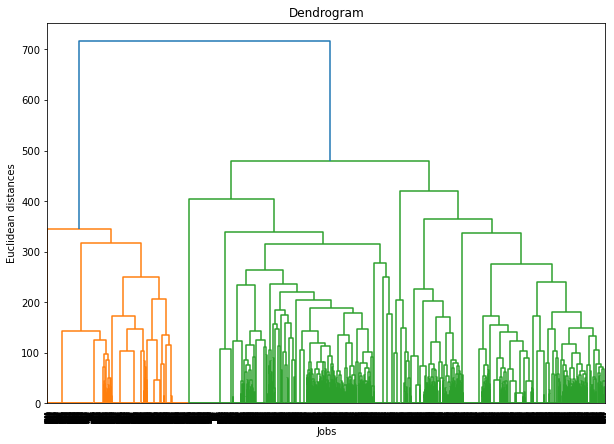

In [16]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(10, 7))  
plt.title('Dendrogram')
plt.xlabel('Jobs')
plt.ylabel('Euclidean distances')
dendrogram = sch.dendrogram(sch.linkage(em_word_arr, method  = "ward"))
plt.show()


In [50]:
em_word_arr.shape

AttributeError: 'list' object has no attribute 'shape'

C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8096 samples in 0.006s...
[t-SNE] Computed neighbors for 8096 samples in 2.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8096
[t-SNE] Computed conditional probabilities for sample 2000 / 8096
[t-SNE] Computed conditional probabilities for sample 3000 / 8096
[t-SNE] Computed conditional probabilities for sample 4000 / 8096
[t-SNE] Computed conditional probabilities for sample 5000 / 8096
[t-SNE] Computed conditional probabilities for sample 6000 / 8096
[t-SNE] Computed conditional probabilities for sample 7000 / 8096
[t-SNE] Computed conditional probabilities for sample 8000 / 8096
[t-SNE] Computed conditional probabilities for sample 8096 / 8096
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.638298
[t-SNE] KL divergence after 1000 iterations: 0.786591


[Text(0.5, 1.0, 'Job titles T-SNE projection')]

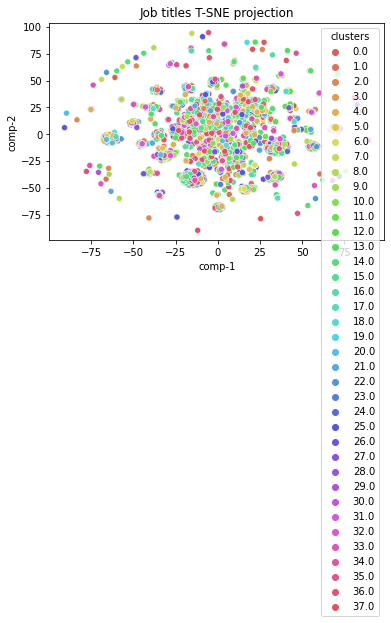

In [37]:
## kmean
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 38)
y_km=km.fit_predict(em_word_arr)
print(list(set(y_km)))
def_of_embedded_part_km = df_harm.head(8096)
def_of_embedded_part_km['clusters'] = list(y_km)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)

df_tsne = pd.DataFrame()
z = tsne.fit_transform(em_word_arr)

df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue= def_of_embedded_part_km['clusters'],
                palette=sns.color_palette("hls", 38),
                data=df_tsne).set(title="Job titles T-SNE projection") #hue=df.y.tolist(),

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.cluster import  hierarchy

#Vectorizing
#X = CountVectorizer().fit_transform(em_word_arr)
X = TfidfTransformer().fit_transform(em_word_arr)
#Clustering
X = X.todense()
threshold = 0.1
Z = hierarchy.linkage(X,"average", metric="cosine")
C = hierarchy.fcluster(Z, threshold, criterion="distance")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8096 samples in 0.004s...


C:\Users\samer\AppData\Local\Temp\ipykernel_27460\2288311583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_of_embedded_part_['clusters'] = list(y_hc)
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 8096 samples in 1.798s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8096
[t-SNE] Computed conditional probabilities for sample 2000 / 8096
[t-SNE] Computed conditional probabilities for sample 3000 / 8096
[t-SNE] Computed conditional probabilities for sample 4000 / 8096
[t-SNE] Computed conditional probabilities for sample 5000 / 8096
[t-SNE] Computed conditional probabilities for sample 6000 / 8096
[t-SNE] Computed conditional probabilities for sample 7000 / 8096
[t-SNE] Computed conditional probabilities for sample 8000 / 8096
[t-SNE] Computed conditional probabilities for sample 8096 / 8096
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.638298
[t-SNE] KL divergence after 1000 iterations: 0.786591


[Text(0.5, 1.0, 'Job titles T-SNE projection')]

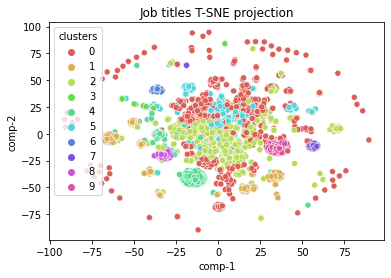

In [52]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean',linkage ='ward') #, 'ward'
y_hc=hc.fit_predict(em_word_arr)
print(list(set(y_hc)))
def_of_embedded_part_ = df.head(8096)
def_of_embedded_part_['clusters'] = list(y_hc)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)

df = pd.DataFrame()
z = tsne.fit_transform(em_word_arr)

df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue= def_of_embedded_part_['clusters'],
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Job titles T-SNE projection") #hue=df.y.tolist(),

[0, 1]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8096 samples in 0.006s...


C:\Users\samer\AppData\Local\Temp\ipykernel_27460\2256414107.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_of_embedded_part_['clusters'] = list(y_hc)
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 8096 samples in 2.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8096
[t-SNE] Computed conditional probabilities for sample 2000 / 8096
[t-SNE] Computed conditional probabilities for sample 3000 / 8096
[t-SNE] Computed conditional probabilities for sample 4000 / 8096
[t-SNE] Computed conditional probabilities for sample 5000 / 8096
[t-SNE] Computed conditional probabilities for sample 6000 / 8096
[t-SNE] Computed conditional probabilities for sample 7000 / 8096
[t-SNE] Computed conditional probabilities for sample 8000 / 8096
[t-SNE] Computed conditional probabilities for sample 8096 / 8096
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.638298
[t-SNE] KL divergence after 1000 iterations: 0.786591


[Text(0.5, 1.0, 'Iris data T-SNE projection')]

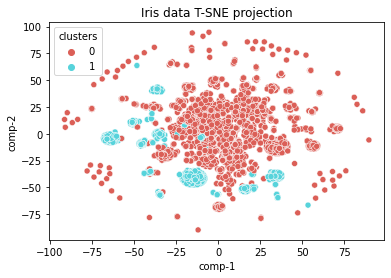

In [20]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(em_word_arr)
print(list(set(y_hc)))
def_of_embedded_part_ = df.head(8096)
def_of_embedded_part_['clusters'] = list(y_hc)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)

df = pd.DataFrame()
z = tsne.fit_transform(em_word_arr)

df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue= def_of_embedded_part_['clusters'],
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Iris data T-SNE projection") #hue=df.y.tolist(),

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

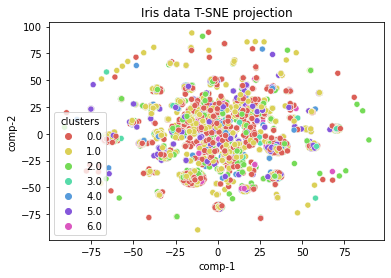

In [150]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(em_word_arr)
print(list(set(y_hc)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [318]:
def_of_embedded_part_1 = df.head(16276)
def_of_embedded_part_1['clusters'] = list(y_hc)

C:\Users\samer\AppData\Local\Temp\ipykernel_22532\1548258561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_of_embedded_part_1['clusters'] = list(y_hc)


In [320]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)

df = pd.DataFrame()
z = tsne.fit_transform(em_word_arr)

df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16276 samples in 0.012s...
[t-SNE] Computed neighbors for 16276 samples in 12.858s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16276
[t-SNE] Computed conditional probabilities for sample 2000 / 16276
[t-SNE] Computed conditional probabilities for sample 3000 / 16276
[t-SNE] Computed conditional probabilities for sample 4000 / 16276
[t-SNE] Computed conditional probabilities for sample 5000 / 16276
[t-SNE] Computed conditional probabilities for sample 6000 / 16276
[t-SNE] Computed conditional probabilities for sample 7000 / 16276
[t-SNE] Computed conditional probabilities for sample 8000 / 16276
[t-SNE] Computed conditional probabilities for sample 9000 / 16276
[t-SNE] Computed conditional probabilities for sample 10000 / 16276
[t-SNE] Computed conditional probabilities for sample 11000 / 16276
[t-SNE] Computed conditional probabilities for sample 12000 / 16276
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

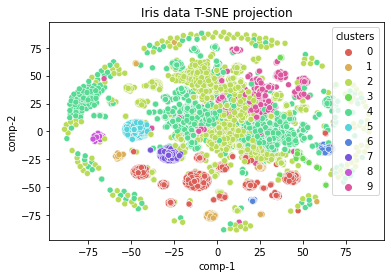

In [321]:
sns.scatterplot(x="comp-1", y="comp-2", hue= def_of_embedded_part_1['clusters'],
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Iris data T-SNE projection") #hue=df.y.tolist(),

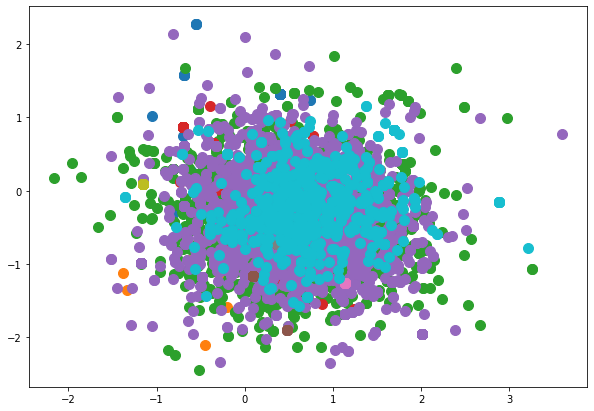

In [166]:
plt.figure(figsize=(10, 7))  
for i in list(set(y_hc)):
    plt.scatter(em_word_arr[y_hc==i, 0], em_word_arr[y_hc==i, 1], s=100, label =f'Cluster {i}')

In [170]:
hc_2 = AgglomerativeClustering(n_clusters =3, affinity = 'euclidean', linkage ='ward')
y_hc_2=hc_2.fit_predict(em_word_arr)
print(list(set(y_hc_2)))

[0, 1, 2]


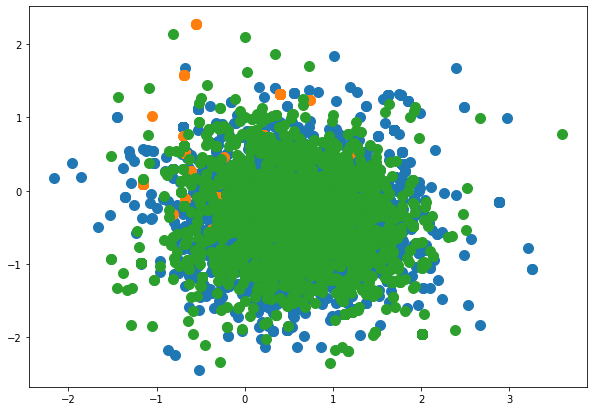

In [171]:
plt.figure(figsize=(10, 7))  
for i in list(set(y_hc_2)):
    plt.scatter(em_word_arr[y_hc_2==i, 0], em_word_arr[y_hc_2==i, 1], s=100, label =f'Cluster {i}')

In [172]:
hc_60 = AgglomerativeClustering(n_clusters =60, affinity = 'euclidean', linkage ='ward')
y_hc_60=hc_2.fit_predict(em_word_arr)
print(list(set(y_hc_60)))

[0, 1, 2]


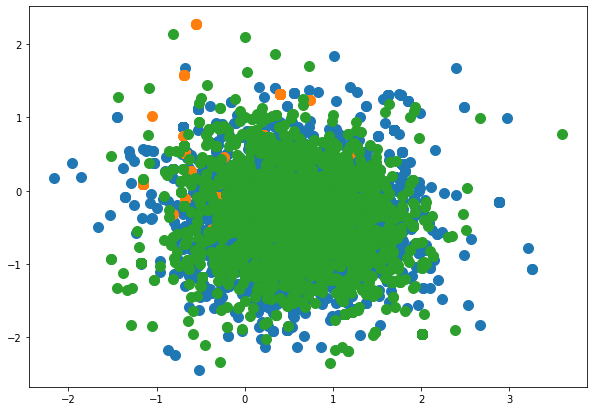

In [173]:
plt.figure(figsize=(10, 7))  
for i in list(set(y_hc_60)):
    plt.scatter(em_word_arr[y_hc_60==i, 0], em_word_arr[y_hc_60==i, 1], s=100, label =f'Cluster {i}')

In [175]:
df.shape, em_word_arr.shape

((58984, 4), (16276, 768))

In [313]:
def_of_embedded_part = df.head(16276)
def_of_embedded_part['clusters'] = list(y_hc_2)

C:\Users\samer\AppData\Local\Temp\ipykernel_22532\3985346592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_of_embedded_part['clusters'] = list(y_hc_2)


In [314]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)

df = pd.DataFrame()
z = tsne.fit_transform(em_word_arr)

df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\samer\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16276 samples in 0.025s...
[t-SNE] Computed neighbors for 16276 samples in 17.691s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16276
[t-SNE] Computed conditional probabilities for sample 2000 / 16276
[t-SNE] Computed conditional probabilities for sample 3000 / 16276
[t-SNE] Computed conditional probabilities for sample 4000 / 16276
[t-SNE] Computed conditional probabilities for sample 5000 / 16276
[t-SNE] Computed conditional probabilities for sample 6000 / 16276
[t-SNE] Computed conditional probabilities for sample 7000 / 16276
[t-SNE] Computed conditional probabilities for sample 8000 / 16276
[t-SNE] Computed conditional probabilities for sample 9000 / 16276
[t-SNE] Computed conditional probabilities for sample 10000 / 16276
[t-SNE] Computed conditional probabilities for sample 11000 / 16276
[t-SNE] Computed conditional probabilities for sample 12000 / 16276
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

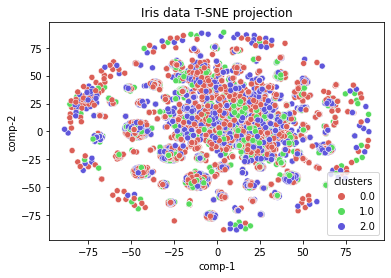

In [317]:
sns.scatterplot(x="comp-1", y="comp-2", hue= def_of_embedded_part['clusters'],
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Iris data T-SNE projection") #hue=df.y.tolist(),

In [176]:
df_embedded = df.head(16276)
df_embedded['groups'] = y_hc
df_embedded

C:\Users\samer\AppData\Local\Temp\ipykernel_22532\3691635218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embedded['groups'] = y_hc


,job_title,frequency,job_category,label,groups
0,cleaner,118,cleaner,0,6
1,education assistant,95,education assistant,1,0
2,driver,91,driver,2,1
3,education assistant,84,education assistant,1,0
4,educator assistant,83,education assistant,1,0
...,...,...,...,...,...
21547,admin,1,admin assistant clerk,10,4
21548,data capture,1,data capturer,27,9
21549,sales assistant,1,sales assistant,8,2
21550,cleaning community,1,cleaner,0,4


In [205]:
cluster_to_labels = []
cluster_list = []
for i in range(10):
    dict_ = {}
    dict_['cluster_number'] = i
    dict_['jobs_category'] = list(set(df_embedded[df_embedded['groups'] == i].job_category.tolist()))
    cluster_to_labels.append(dict_)

    cluster_list.append([i] + list(set(df_embedded[df_embedded['groups'] == i].job_category.tolist())))


In [207]:
#pd.DataFrame(cluster_to_labels)
pd.DataFrame(cluster_to_labels)


,cluster_number,jobs_category
0,0,"[childcare, covid19 screener, fitness coach, e..."
1,1,"[admin assistant clerk, intern, sales assistan..."
2,2,"[general worker, hospitality, intern, educatio..."
3,3,"[tutor, admin assistant clerk, childcare, educ..."
4,4,"[general worker, hospitality, intern, educatio..."
5,5,[cashier]
6,6,[cleaner]
7,7,"[cleaner, general worker]"
8,8,[education assistant]
9,9,"[general worker, hospitality, intern, educatio..."


In [270]:
#cluster_to_labels[0], cluster_to_labels[1]
commonties_list_total = []
for idx_1, cluster_dict in enumerate(cluster_to_labels):
    cluster_number = cluster_dict['cluster_number']
    categories = cluster_dict['jobs_category']
    temp_list = []
    store_to_list = True
    for idx_2, cluster_dict_2 in enumerate(cluster_to_labels):
        if(idx_1 == idx_2):
            continue
        cluster_number_2 = cluster_dict_2['cluster_number']
        categories_2 = cluster_dict_2['jobs_category']
        
        unique_jobs = set(categories) - set(categories_2)
        if(len(list(unique_jobs)) == 0):
            continue
        common_jobs = list(set(categories)-unique_jobs)

        if(len(common_jobs) != 0):

            temp_list.append([cluster_number_2,common_jobs])

        
    if store_to_list:
        dict_ = {}#
        dict_['cluster_number'] = cluster_number
        dict_['assigned_cluster'] = categories
        dict_['commonties'] = temp_list
        commonties_list_total.append(dict_)
    

In [271]:
list_commonties = []
def closest_cluster(dict_cluster_info):
    most_common = []
    assigned_cluster = dict_cluster_info['assigned_cluster']
    num_categories = len(assigned_cluster)
    thresshold = int(num_categories * 0.6666)
    for common_cluster in dict_cluster_info['commonties']:
        cc_ = common_cluster[1]
        num_common_cluster = len(cc_)
        if (num_common_cluster>=thresshold):
            most_common.append(common_cluster[0])
    return {'source_cluster' : dict_cluster_info['cluster_number'],
        "most_common":most_common}

In [266]:
commonties_list_total

[{'cluster_number': 0,
  'assigned_cluster': ['childcare',
   'covid19 screener',
   'fitness coach',
   'education assistant',
   'admin assistant clerk',
   'tutor'],
  'commonties': [[1, ['admin assistant clerk']],
   [3, ['tutor', 'admin assistant clerk', 'childcare', 'education assistant']],
   [8, ['education assistant']],
   [9,
    ['childcare',
     'covid19 screener',
     'education assistant',
     'admin assistant clerk',
     'tutor']]]},
 {'cluster_number': 1,
  'assigned_cluster': ['admin assistant clerk',
   'intern',
   'sales assistant',
   'driver'],
  'commonties': [[0, ['admin assistant clerk']],
   [3, ['admin assistant clerk']],
   [9, ['admin assistant clerk', 'intern', 'sales assistant']]]},
 {'cluster_number': 2,
  'assigned_cluster': ['general worker',
   'hospitality',
   'intern',
   'education assistant',
   'admin assistant clerk',
   'manager',
   'brand promoter',
   'childcare',
   'sales assistant',
   'covid19 screener',
   'data capturer',
   'cons

In [279]:
#list_commonties.append()
cluster_common_with_clusters = [closest_cluster(dicty) for dicty in commonties_list_total]
len(cluster_common_with_clusters)

10

In [280]:
pd.DataFrame(cluster_common_with_clusters)

,source_cluster,most_common
0,0,"[3, 9]"
1,1,[9]
2,2,[9]
3,3,[]
4,4,"[2, 9]"
5,5,[]
6,6,[]
7,7,[6]
8,8,[]
9,9,[2]


In [282]:
for i in [0,1,2,4,7,9]:
    print(f"category: {i}")
    print(set(df_embedded[df_embedded['groups']== i].job_category.tolist()))
    print("\n######################################## \n")

category: 0
{'childcare', 'covid19 screener', 'fitness coach', 'education assistant', 'admin assistant clerk', 'tutor'}

######################################## 

category: 1
{'admin assistant clerk', 'intern', 'sales assistant', 'driver'}

######################################## 

category: 2
{'general worker', 'hospitality', 'intern', 'education assistant', 'admin assistant clerk', 'manager', 'brand promoter', 'childcare', 'sales assistant', 'covid19 screener', 'data capturer', 'construction', 'security', 'tutor', 'picker packer', 'maintenance', 'facilitator', 'waitron', 'machine operator', 'petrol attendent', 'it technician', 'learnership', 'research fieldworker', 'software tester', 'food preparation', 'driver', 'stockroom assistant', 'designer', 'receptionist', 'cashier', 'cleaner', 'No description', 'call centre agent', 'fitness coach', 'advisers/consultants', 'finance'}

######################################## 

category: 4
{'general worker', 'hospitality', 'intern', 'educatio

In [278]:
set(df_embedded[df_embedded['groups']== 3].job_category.tolist())

{'admin assistant clerk', 'childcare', 'education assistant', 'tutor'}

In [281]:
for i in [3,5,6,8]:
    print(f"category: {i}")
    print(set(df_embedded[df_embedded['groups']== i].job_category.tolist()))
    print("\n######################################## \n")

category: 3
{'tutor', 'admin assistant clerk', 'childcare', 'education assistant'}

######################################## 

category: 5
{'cashier'}

######################################## 

category: 6
{'cleaner'}

######################################## 

category: 8
{'education assistant'}

######################################## 



In [303]:
df_embedded_3 = df.head(16276)
df_embedded_3['groups'] = y_hc_2
df_embedded_3


def get_cluster_list(df):
    cluster_to_labels = []
    cluster_list = []
    for i in range(df.groups.unique().shape[0]):
        dict_ = {}
        dict_['cluster_number'] = i
        dict_['jobs_category'] = list(set(df[df['groups'] == i].job_category.tolist()))
        cluster_to_labels.append(dict_)

        cluster_list.append([i] + list(set(df[df['groups'] == i].job_category.tolist())))
    return cluster_to_labels

#cluster_to_labels[0], cluster_to_labels[1]
def common_list_(cluster_list_to_label):
    commonties_list_total = []
    for idx_1, cluster_dict in enumerate(cluster_list_to_label):
        cluster_number = cluster_dict['cluster_number']
        categories = cluster_dict['jobs_category']
        temp_list = []
        store_to_list = True
        for idx_2, cluster_dict_2 in enumerate(cluster_list_to_label):
            if(idx_1 == idx_2):
                continue
            cluster_number_2 = cluster_dict_2['cluster_number']
            categories_2 = cluster_dict_2['jobs_category']

            unique_jobs = set(categories) - set(categories_2)
            if(len(list(unique_jobs)) == 0):
                continue
            common_jobs = list(set(categories)-unique_jobs)

            if(len(common_jobs) != 0):

                temp_list.append([cluster_number_2,common_jobs])


        if store_to_list:
            dict_ = {}#
            dict_['cluster_number'] = cluster_number
            dict_['assigned_cluster'] = categories
            dict_['commonties'] = temp_list
            commonties_list_total.append(dict_)
    return commonties_list_total

C:\Users\samer\AppData\Local\Temp\ipykernel_22532\2416992121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embedded_3['groups'] = y_hc_2


In [307]:
xx = common_list_(get_cluster_list(df_embedded_3))
ll_ = [closest_cluster(cluster_data) for cluster_data in xx]
ll_
for i in range(3):
    print(f"category: {i}")
    print(set(df_embedded_3[df_embedded_3['groups']== i].job_category.tolist()))
    print("\n######################################## \n")

category: 0
{'general worker', 'hospitality', 'intern', 'education assistant', 'admin assistant clerk', 'manager', 'brand promoter', 'childcare', 'sales assistant', 'covid19 screener', 'data capturer', 'construction', 'security', 'tutor', 'picker packer', 'maintenance', 'facilitator', 'waitron', 'machine operator', 'petrol attendent', 'it technician', 'learnership', 'research fieldworker', 'software tester', 'food preparation', 'driver', 'stockroom assistant', 'designer', 'receptionist', 'cashier', 'cleaner', 'No description', 'call centre agent', 'fitness coach', 'caregiver', 'advisers/consultants', 'finance'}

######################################## 

category: 1
{'childcare', 'covid19 screener', 'fitness coach', 'education assistant', 'admin assistant clerk', 'tutor'}

######################################## 

category: 2
{'general worker', 'hospitality', 'intern', 'education assistant', 'admin assistant clerk', 'manager', 'brand promoter', 'childcare', 'sales assistant', 'covid19

In [305]:
pd.DataFrame(ll_)

,source_cluster,most_common
0,0,[]
1,1,[]
2,2,[0]
